In [ ]:
##Dataset  merge and feature engineering

In [2]:
from config import DATABASE_NAME, BUCKET, REGION, S3_STAGING_DIR

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import sagemaker
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
import boto3
import time

region = REGION
role = sagemaker.get_execution_role()
session = sagemaker.Session()

print("Libraries loaded")

Libraries loaded


In [84]:
base_path = f"s3://{BUCKET}/raw/corporacion_favorita"

In [85]:
#Load All 5 Datasets From S3

train = pd.read_csv(f"{base_path}/train/train.csv")
transactions = pd.read_csv(f"{base_path}/transactions/transactions.csv")
stores = pd.read_csv(f"{base_path}/stores/stores.csv")
holidays_events = pd.read_csv(f"{base_path}/holidays/holidays_events.csv")
oil = pd.read_csv(f"{base_path}/oil/oil.csv")

print("All raw datasets loaded successfully")


All raw datasets loaded successfully


In [86]:
#Convert Date Columns

train['date'] = pd.to_datetime(train['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
oil['date'] = pd.to_datetime(oil['date'])


In [ ]:
"

| Dataset         | Join Key        |
| --------------- | --------------- |
| train           | date, store_nbr |
| transactions    | date, store_nbr |
| stores          | store_nbr       |
| holidays_events | date            |
| oil             | date            |


In [87]:
#Start With Train as Base

df = train.copy()
print(df.shape)

(3000888, 6)


In [88]:
#Merge Transactions data with train

'''Merge on:
date
store_nbr'''

df = df.merge(
    transactions,
    on=['date', 'store_nbr'],
    how='left'
)

print("After merging transactions:", df.shape)


After merging transactions: (3000888, 7)


In [89]:
#Merge Stores
'''
Merge on:
store_nbr'''

df = df.merge(
    stores,
    on='store_nbr',
    how='left'
)

print("After merging stores:", df.shape)


After merging stores: (3000888, 11)


In [90]:
#Merge Oil
'''
Merge on:
date'''

df = df.merge(
    oil,
    on='date',
    how='left'
)

print("After merging oil:", df.shape)


After merging oil: (3000888, 12)


In [91]:
df['dcoilwtico'] = df['dcoilwtico'].ffill()

In [92]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'city', 'state', 'type', 'cluster', 'dcoilwtico'],
      dtype='object')

In [ ]:
#Merge Holidays_events

In [93]:
holidays_events.groupby("date").size().sort_values(ascending=False).head(10)

date
2014-06-25    4
2013-06-25    3
2016-06-25    3
2017-06-25    3
2012-06-25    3
2015-06-25    3
2017-12-22    2
2013-07-03    2
2013-05-12    2
2012-12-31    2
dtype: int64

In [ ]:
"
What This Means

For example:

📅 2014-06-25 → 4 rows in holidays table

That means on that date there are 4 different holiday/event records.

When you merge with train:

If train has 10,000 rows for that date
After merge → 10,000 × 4 = 40,000 rows

That is exactly why your dataset increased by 7,392 rows.
This is a many-to-one merge becoming many-to-many.

Why June 25 Appears So Often?

In Ecuador:
Some holidays are regional
Some are local
Some are events
Some are transferred
So one calendar day can have:
1 national holiday
1 regional holiday
1 local holiday
1 event

= 4 rows for same date

In [94]:
df.shape

(3000888, 12)

In [95]:
#Prepare Holidays Data

hol = holidays_events.copy()
# Remove transferred holidays
hol = hol[hol["transferred"] == False]

In [96]:
#NATIONAL Holidays

national = hol[hol["locale"] == "National"].copy()

national["is_national"] = 1

national = national.groupby("date", as_index=False).agg({
    "is_national": "max"
})

# Merge
df = df.merge(national, on="date", how="left")

df["is_national"] = df["is_national"].fillna(0)


In [97]:
#REGIONAL Holidays

regional = hol[hol["locale"] == "Regional"].copy()

regional["is_regional"] = 1

regional = regional.groupby(
    ["date", "locale_name"],
    as_index=False
).agg({
    "is_regional": "max"
})

df = df.merge(
    regional,
    left_on=["date", "state"],
    right_on=["date", "locale_name"],
    how="left"
)

df.drop("locale_name", axis=1, inplace=True)

df["is_regional"] = df["is_regional"].fillna(0)


In [98]:
#LOCAL Holidays

local = hol[hol["locale"] == "Local"].copy()

local["is_local"] = 1

local = local.groupby(
    ["date", "locale_name"],
    as_index=False
).agg({
    "is_local": "max"
})

df = df.merge(
    local,
    left_on=["date", "city"],
    right_on=["date", "locale_name"],
    how="left"
)

df.drop("locale_name", axis=1, inplace=True)

df["is_local"] = df["is_local"].fillna(0)


In [ ]:
"
"For every row in df, check:

Does the date match?

Does the state match locale_name?
If yes → attach holiday info"

What Happens Internally?abs

In df:
| date       | store_nbr | state     |
| ---------- | --------- | --------- |
| 2013-07-25 | 5         | Pichincha |
| 2013-07-25 | 8         | Guayas    |

In holidays (regional):
| date       | locale_name | is_regional |
| ---------- | ----------- | ----------- |
| 2013-07-25 | Pichincha   | 1           |

After merge:
| date       | store_nbr | state     | is_regional |
| ---------- | --------- | --------- | ----------- |
| 2013-07-25 | 5         | Pichincha | 1           |
| 2013-07-25 | 8         | Guayas    | NaN         

df["is_regional"] = df["is_regional"].fillna(0)
| state     | is_regional |
| --------- | ----------- |
| Pichincha | 1           |
| Guayas    | 0           |


In [99]:
df.rename(columns={"type": "store_type"}, inplace=True)

In [100]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,store_type,cluster,dcoilwtico,is_national,is_regional,is_local
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,NaN,1.0,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,NaN,1.0,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,NaN,1.0,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,NaN,1.0,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,NaN,1.0,0.0,0.0


In [101]:
print(df.shape)

(3000888, 15)


In [7]:
#store the merged data into train_merged.csv and store in s3 bucket
df.to_csv(
    f"s3://{BUCKET}/processed/merged/train_merged.csv",
    index=False
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 #store the merged data into train_merged.csv and store in s3 bucket                          │
│ ❱ 2 df.to_csv(                                                                                   │
│   3 │   f"s3://{BUCKET}/processed/merged/train_merged.csv",                                      │
│   4 │   index=False                                                                              │
│   5 )                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'df' is not defined

In [ ]:
##Feature Engineering 

In [4]:
#read the stored data
df = pd.read_csv(
    f"s3://{BUCKET}/processed/merged/train_merged.csv",
    parse_dates=['date']
)


In [5]:
#list all the columns present in the data
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'city', 'state', 'store_type', 'cluster', 'dcoilwtico',
       'is_national', 'is_regional', 'is_local'],
      dtype='object')

In [6]:
#Check the information regarding the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 15 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   transactions  float64       
 7   city          object        
 8   state         object        
 9   store_type    object        
 10  cluster       int64         
 11  dcoilwtico    float64       
 12  is_national   float64       
 13  is_regional   float64       
 14  is_local      float64       
dtypes: datetime64[ns](1), float64(6), int64(4), object(4)
memory usage: 343.4+ MB


In [7]:
#check for null values
df.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
transactions    245784
city                 0
state                0
store_type           0
cluster              0
dcoilwtico        1782
is_national          0
is_regional          0
is_local             0
dtype: int64

In [8]:
#sort the data via store_nbr,family and date
df = df.sort_values(["store_nbr", "family", "date"])
df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,store_type,cluster,dcoilwtico,is_national,is_regional,is_local
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,NaN,1.0,0.0,0.0
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,2111.0,Quito,Pichincha,D,13,93.14,0.0,0.0,0.0
3564,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,1833.0,Quito,Pichincha,D,13,92.97,0.0,0.0,0.0
5346,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,1863.0,Quito,Pichincha,D,13,93.12,0.0,0.0,0.0
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,1509.0,Quito,Pichincha,D,13,93.12,1.0,0.0,0.0


In [ ]:
"
1) Why are transactions NaN?

Important concept:
Your dataset is at:
store_nbr + family + date
But transactions dataset is at:
store_nbr + date

So when you merged:

For some dates, transactions don’t exist
Example: 2013-01-01 (holiday — store closed)
So merge gives NaN
This is expected behavior.

Logical reasoning:

If there are no transactions recorded →
It likely means store was closed → so transactions = 0

So safest fix:

df["transactions"] = df["transactions"].fillna(0)
✔ This is correct for retail forecasting.


2) Why is dcoilwtico NaN?
Oil prices:
Some dates missing
Possibly weekends or missing reporting days
Oil price is continuous economic variable, so:

🚫 Do NOT replace with 0
That would distort model.

Correct Way to Handle Oil Price

Use forward fill (carry last known value):

df["dcoilwtico"] = df["dcoilwtico"].fillna(method="ffill")

Then if still any NaNs at beginning:

df["dcoilwtico"] = df["dcoilwtico"].fillna(method="bfill")
✔ This preserves economic trend.

In [9]:
# Fill transactions NaN
df["transactions"] = df["transactions"].fillna(0)

# Fill oil prices NaN
df["dcoilwtico"] = df["dcoilwtico"].fillna(method="ffill")
df["dcoilwtico"] = df["dcoilwtico"].fillna(method="bfill")

# Final check
print(df.isna().sum())

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
transactions    0
city            0
state           0
store_type      0
cluster         0
dcoilwtico      0
is_national     0
is_regional     0
is_local        0
dtype: int64


In [10]:
#Time Features (Mandatory)

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek
df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)

df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
df["is_month_start"] = df["date"].dt.is_month_start.astype(int)
df["is_month_end"] = df["date"].dt.is_month_end.astype(int)

In [ ]:
"
These capture:

Weekly seasonality
Monthly salary effect (15th, month-end)
Weekend patterns

In [11]:
#Lag Features(Sales)

lags = [1, 7, 14, 28]

for lag in lags:
    df[f"sales_lag_{lag}"] = (
        df.groupby(["store_nbr", "family"])["sales"]
        .shift(lag)
    )

In [12]:
"
Why?

Lag 1 → yesterday effect
Lag 7 → weekly pattern
Lag 14 → bi-weekly salary cycle
Lag 28 → monthly pattern
These directly capture patterns you saw in ACF.

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ "                                                                                                │
│ ▲                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SyntaxError: unterminated string literal (detected at line 1)

In [12]:
#Rolling Mean Features(Sales)

windows = [7, 14, 30]

for window in windows:
    df[f"rolling_mean_{window}"] = (
        df.groupby(["store_nbr", "family"])["sales"]
        .shift(1)
        .rolling(window)
        .mean()
    )


In [13]:
#Promotion Features-Captures promotion intensity trend.

df["promo_last_7"] = (
    df.groupby(["store_nbr", "family"])["onpromotion"]
    .shift(1)
    .rolling(7)
    .sum()
)

df["promo_last_14"] = (
    df.groupby(["store_nbr", "family"])["onpromotion"]
    .shift(1)
    .rolling(14)
    .sum()
)

In [14]:
#Create lag features for transactions column

lags = [7, 14, 30]

for lag in lags:
    df[f"trans_lag_{lag}"] = (
        df.groupby("store_nbr")["transactions"]
          .shift(lag)
    )


In [15]:
#Create rolling mean features for transactions column

windows = [7, 14, 30]

for window in windows:
    df[f"trans_roll_{window}"] = (
        df.groupby("store_nbr")["transactions"]
          .shift(1)
          .rolling(window)
          .mean()
    )

In [16]:
#Holiday Interaction Features

df["holiday_promo"] = df["is_national"] * df["onpromotion"]
df["holiday_weekend"] = df["is_national"] * df["is_weekend"]

In [17]:
#Holiday Season Feature

df["is_holiday_season"] = (
    (df["month"].isin([11, 12])) | 
    (df["is_national"] == 1)
).astype(int)

In [ ]:
"
From your EDA:

December spike
Likely driven by Christmas + year-end spending
November may include early holiday buildup

In [18]:
#Cyclical Encoding
import numpy as np

df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)


In [ ]:
"
What This Does

It converts month into coordinates on a circle:
month_sin → vertical position
month_cos → horizontal position
Now:

December and January become close in value
March and April become close

Opposite months become opposite points
The model now understands seasonality smoothly.


In [19]:
#Oil Price Features

df["oil_lag_7"] = df["dcoilwtico"].shift(7)
df["oil_rolling_30"] = df["dcoilwtico"].rolling(30).mean()

In [20]:
#Cyclic encoding for week

df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

In [21]:
#Interaction Feature (December + Friday)

df['december_friday'] = ((df['month']==12) & (df['dayofweek']==4)).astype(int)

In [ ]:
"
From EDA:

December = spike
Friday = high sales
Combination may explode sales
That’s interaction modeling.

In [22]:
#Earthquake Feature

df['is_earthquake_period'] = (
    (df['date'] >= '2016-04-16') & 
    (df['date'] <= '2016-05-31')
).astype(int)

In [23]:
#Payroll Feature (VERY IMPORTANT)
'''
Public wages paid:
15th
Last day of month'''

df["is_payday"] = (
    (df["date"].dt.day == 15) |
    (df["date"].dt.is_month_end)
).astype(int)

In [24]:
df.isna().sum()

id                          0
date                        0
store_nbr                   0
family                      0
sales                       0
onpromotion                 0
transactions                0
city                        0
state                       0
store_type                  0
cluster                     0
dcoilwtico                  0
is_national                 0
is_regional                 0
is_local                    0
year                        0
month                       0
day                         0
dayofweek                   0
weekofyear                  0
is_weekend                  0
is_month_start              0
is_month_end                0
sales_lag_1              1782
sales_lag_7             12474
sales_lag_14            24948
sales_lag_28            49896
rolling_mean_7          12474
rolling_mean_14         24948
rolling_mean_30         53460
promo_last_7            12474
promo_last_14           24948
trans_lag_7               378
trans_lag_

In [25]:
df = df.dropna()

In [26]:
df = df.rename(columns={
    "rolling_mean_7": "sales_rolling_mean_7",
    "rolling_mean_14 ": "sales_rolling_mean_14 ",
    "rolling_mean_30": "sales_rolling_mean_30"
})

In [27]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'city', 'state', 'store_type', 'cluster', 'dcoilwtico',
       'is_national', 'is_regional', 'is_local', 'year', 'month', 'day',
       'dayofweek', 'weekofyear', 'is_weekend', 'is_month_start',
       'is_month_end', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14',
       'sales_lag_28', 'sales_rolling_mean_7', 'rolling_mean_14',
       'sales_rolling_mean_30', 'promo_last_7', 'promo_last_14', 'trans_lag_7',
       'trans_lag_14', 'trans_lag_30', 'trans_roll_7', 'trans_roll_14',
       'trans_roll_30', 'holiday_promo', 'holiday_weekend',
       'is_holiday_season', 'month_sin', 'month_cos', 'oil_lag_7',
       'oil_rolling_30', 'dow_sin', 'dow_cos', 'december_friday',
       'is_earthquake_period', 'is_payday'],
      dtype='object')

In [28]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,store_type,...,is_holiday_season,month_sin,month_cos,oil_lag_7,oil_rolling_30,dow_sin,dow_cos,december_friday,is_earthquake_period,is_payday
53460,53460,2013-01-31,1,AUTOMOTIVE,0.0,0,1707.0,Quito,Pichincha,D,...,0,0.500000,0.866025,95.35,94.682000,0.433884,-0.900969,0,0,1
55242,55242,2013-02-01,1,AUTOMOTIVE,3.0,0,1806.0,Quito,Pichincha,D,...,0,0.866025,0.500000,95.15,94.826000,-0.433884,-0.900969,0,0,0
57024,57024,2013-02-02,1,AUTOMOTIVE,0.0,0,1377.0,Quito,Pichincha,D,...,0,0.866025,0.500000,95.15,94.975667,-0.974928,-0.222521,0,0,0
58806,58806,2013-02-03,1,AUTOMOTIVE,0.0,0,531.0,Quito,Pichincha,D,...,0,0.866025,0.500000,95.15,95.120333,-0.781831,0.623490,0,0,0
60588,60588,2013-02-04,1,AUTOMOTIVE,5.0,0,1714.0,Quito,Pichincha,D,...,0,0.866025,0.500000,95.95,95.223333,0.000000,1.000000,0,0,0


In [ ]:
#EDA during Earthquake period(2016-04-16 to 2016-05-31)

In [29]:
quake_df = df[
    (df['date'] >= '2016-04-16') & 
    (df['date'] <= '2016-05-31')
].copy()

print("Rows in earthquake period:", quake_df.shape[0])

Rows in earthquake period: 81972


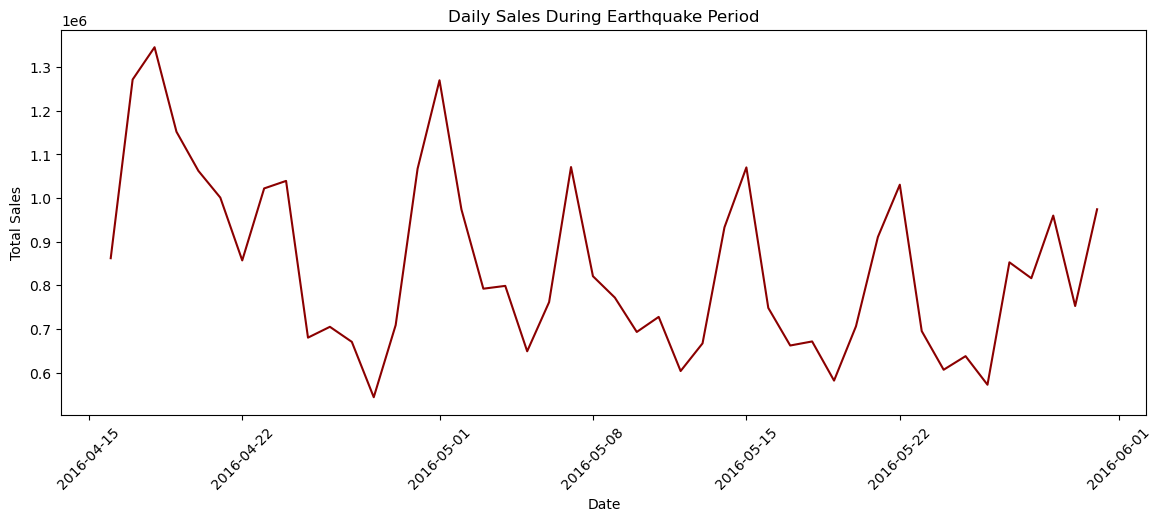

In [30]:
#Daily Total Sales During Earthquake
import matplotlib.pyplot as plt
daily_quake = quake_df.groupby('date').agg({
    'sales': 'sum',
    'transactions': 'sum'
}).reset_index()

plt.figure(figsize=(14,5))
plt.plot(daily_quake['date'], daily_quake['sales'], color='darkred')
plt.title("Daily Sales During Earthquake Period")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()


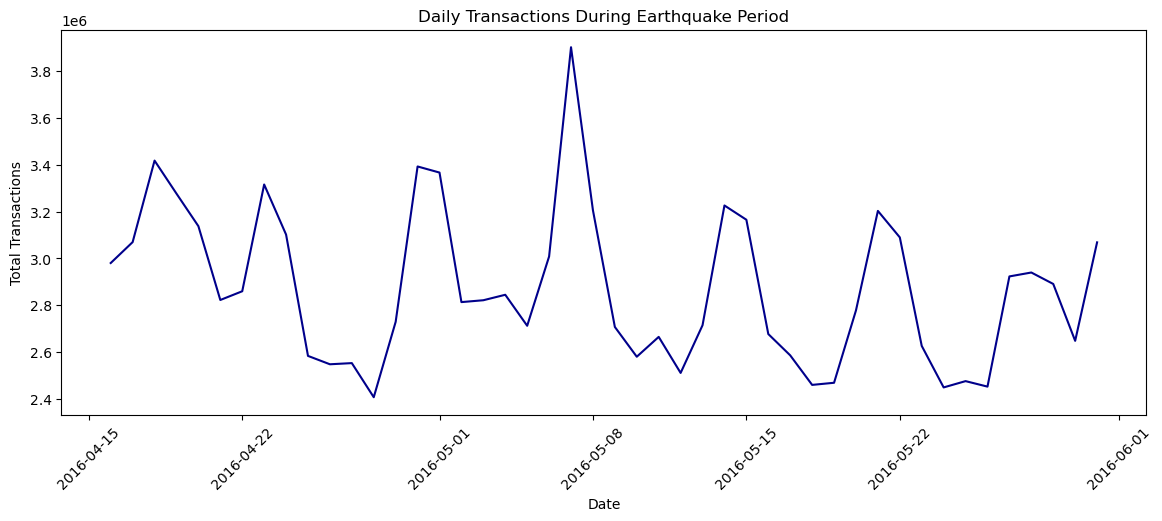

In [31]:
#Daily Transactions During Earthquake

plt.figure(figsize=(14,5))
plt.plot(daily_quake['date'], daily_quake['transactions'], color='darkblue')
plt.title("Daily Transactions During Earthquake Period")
plt.xlabel("Date")
plt.ylabel("Total Transactions")
plt.xticks(rotation=45)
plt.show()

In [32]:
family_spike = quake_df.groupby('family')['sales'].sum().sort_values(ascending=False)

family_spike.head(10)


family
GROCERY I        1.226868e+07
BEVERAGES        8.338266e+06
PRODUCE          5.614075e+06
CLEANING         2.986113e+06
DAIRY            2.229397e+06
BREAD/BAKERY     1.369386e+06
POULTRY          9.614768e+05
PERSONAL CARE    9.123300e+05
MEATS            8.797362e+05
HOME CARE        7.831560e+05
Name: sales, dtype: float64

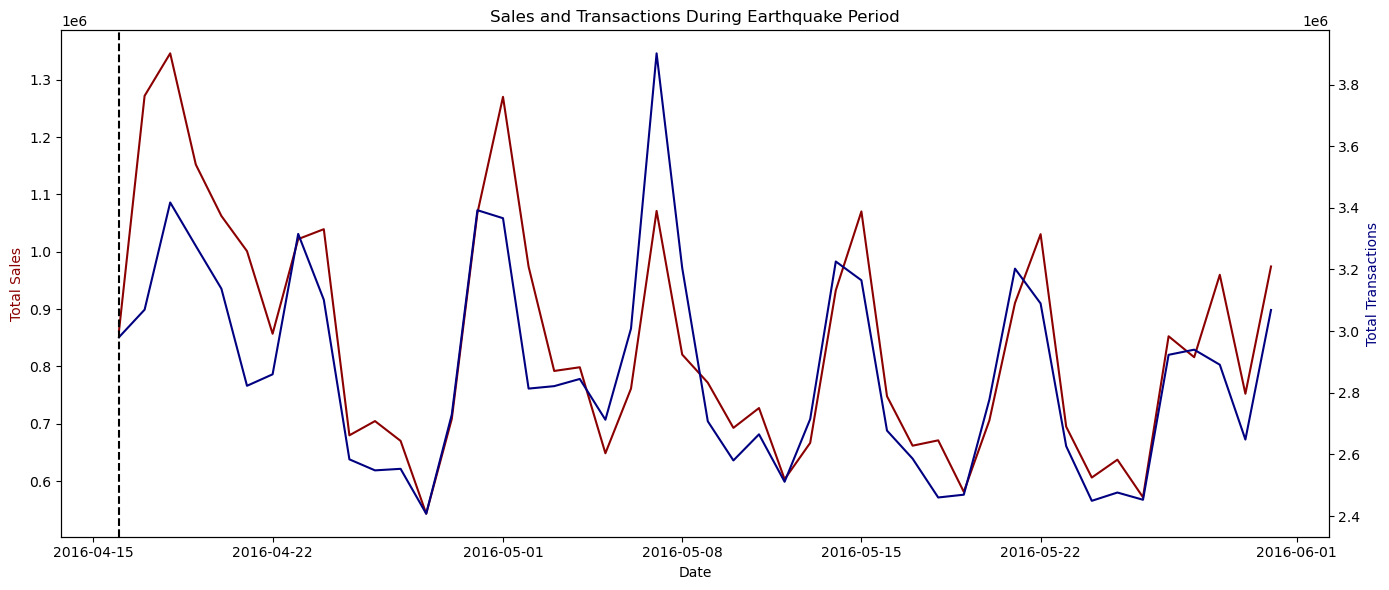

In [33]:
daily_quake = quake_df.groupby('date').agg({
    'sales': 'sum',
    'transactions': 'sum'
}).reset_index()

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14,6))

# Sales (Left Y-axis)
ax1.plot(daily_quake['date'], 
         daily_quake['sales'], 
         color='darkred',
         label='Sales')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales', color='darkred')

# Transactions (Right Y-axis)
ax2 = ax1.twinx()
ax2.plot(daily_quake['date'], 
         daily_quake['transactions'], 
         color='navy',
         label='Transactions')
ax2.set_ylabel('Total Transactions', color='navy')

# Earthquake vertical line
plt.axvline(pd.to_datetime('2016-04-16'),
            color='black',
            linestyle='--',
            label='Earthquake Date')

plt.title('Sales and Transactions During Earthquake Period')
fig.tight_layout()
plt.show()


In [ ]:
"
Title: Sales and Transactions During Earthquake Period

🔴 Red line = Total Sales
🔵 Blue line = Total Transactions
🟢 Vertical dashed line = Earthquake date
Time period: Mid-April to End of May 2016


Relationship Between Sales and Transactions

Overall observation:

Sales and transactions move together most of the time.

When transactions increase → sales increase.
When transactions decrease → sales decrease.

This suggests:
Sales≈Transactions×Average Order Value
There is a strong positive correlation.

Impact Around Earthquake Date
The dashed vertical line marks the earthquake.

Immediately after the earthquake:
There is a noticeable spike in both sales and transactions.
This suggests increased consumer activity (possibly panic buying or emergency purchasing).
This is common behavior after disasters.

Weekly Cyclical Pattern:

After the spike, both lines show:
Regular ups and downs
Likely weekly seasonality (e.g., weekends vs weekdays)
The pattern repeats roughly every 7 days.

Important Observation:
There is one interesting moment:
    
Around early May, transactions spike higher than sales.
This may indicate:
More small purchases
Lower average order value that week
So sales do not always increase proportionally with transactions.

Average Sales 30 Days BEFORE Earthquake: 422.03
Average Sales 30 Days AFTER Earthquake: 495.27
Percentage Change: 17.36 %


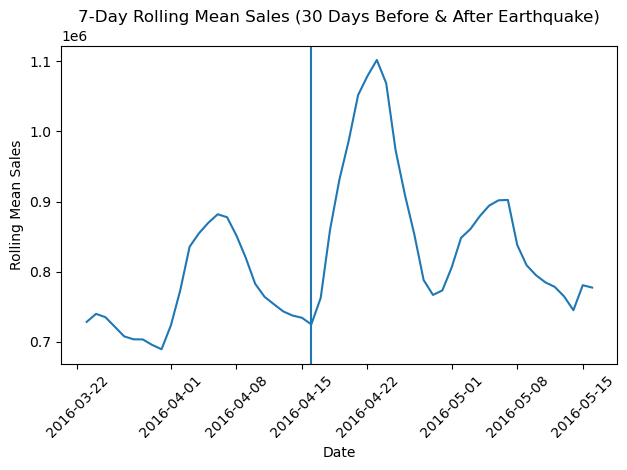

In [34]:
#30-Day Before vs After Earthquake Analysis

import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime
df['date'] = pd.to_datetime(df['date'])

earthquake_date = pd.to_datetime("2016-04-16")

# Define periods
before_period = df[(df['date'] >= earthquake_date - pd.Timedelta(days=30)) & 
                   (df['date'] < earthquake_date)]

after_period = df[(df['date'] > earthquake_date) & 
                  (df['date'] <= earthquake_date + pd.Timedelta(days=30))]

# ---- Compute averages ----
avg_sales_before = before_period['sales'].mean()
avg_sales_after = after_period['sales'].mean()

percent_change = ((avg_sales_after - avg_sales_before) / avg_sales_before) * 100

print("Average Sales 30 Days BEFORE Earthquake:", round(avg_sales_before, 2))
print("Average Sales 30 Days AFTER Earthquake:", round(avg_sales_after, 2))
print("Percentage Change:", round(percent_change, 2), "%")


# ---- Daily aggregation for smoother visualization ----
daily = df.groupby('date')['sales'].sum().reset_index()

window = daily[(daily['date'] >= earthquake_date - pd.Timedelta(days=30)) &
               (daily['date'] <= earthquake_date + pd.Timedelta(days=30))]

# Use rolling mean (7-day)
window['rolling_mean_7'] = window['sales'].rolling(7).mean()

# ---- Plot ----
plt.figure()
plt.plot(window['date'], window['rolling_mean_7'])
plt.axvline(earthquake_date)
plt.title("7-Day Rolling Mean Sales (30 Days Before & After Earthquake)")
plt.xlabel("Date")
plt.ylabel("Rolling Mean Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
"
What This Graph Shows

X-axis → Date
Y-axis → 7-day rolling mean of sales
Vertical blue line → April 16, 2016 (Earthquake date)
This is already smoothed (weekly noise removed).

Before Earthquake (Left of Blue Line)

Sales trend:
Slight decline
Moving between ~700k – 880k
No strong upward momentum
Looks relatively stable but slightly soft
So:
Pre-earthquake sales were moderate and slightly declining.

Immediately After Earthquake
Very important observation:
    
Right after April 16:
Sales increase sharply
Peak reaches ~1.1M
That is a huge jump compared to pre-period
This suggests:

👉 Panic buying
👉 Emergency purchases
👉 Stockpiling behavior

This is a classic shock-response spike.

After the Spike
After the peak:
Sales decline
Return toward 800k–900k range
Stabilizes lower than spike
This suggests:
Temporary demand surge → then normalization

Business Interpretation

What likely happened:
Earthquake hits April 16
People rush to stores
Emergency supplies spike sales
After 1–2 weeks demand stabilizes

In [35]:
#Count how many holiday days during earthquake

# Define earthquake period
start = '2016-04-16'
end = '2016-05-31'

df_eq = df[
    (df['date'] >= start) &
    (df['date'] <= end)
]

# Count how many holiday days
df_eq.groupby('date')[['is_national','is_regional','is_local']].max().reset_index()

,date,is_national,is_regional,is_local
0,2016-04-16,1.0,0.0,0.0
1,2016-04-17,1.0,0.0,0.0
2,2016-04-18,1.0,0.0,0.0
3,2016-04-19,1.0,0.0,0.0
4,2016-04-20,1.0,0.0,0.0
5,2016-04-21,1.0,0.0,1.0
6,2016-04-22,1.0,0.0,0.0
7,2016-04-23,1.0,0.0,0.0
8,2016-04-24,1.0,0.0,0.0
9,2016-04-25,1.0,0.0,0.0


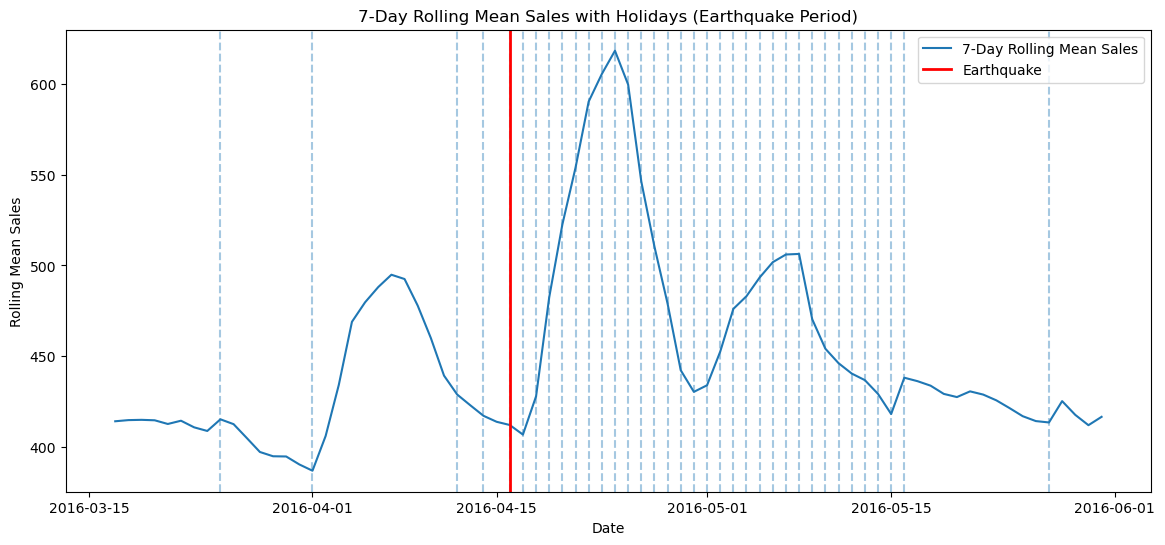

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# ================================
# Define Period (30 days before & after earthquake)
# ================================
start = '2016-03-17'
end   = '2016-05-31'

df_period = df[
    (df['date'] >= start) &
    (df['date'] <= end)
].copy()

# ================================
# Get Holiday Dates
# ================================
holiday_dates = df_period[
    (df_period['is_national'] == 1) |
    (df_period['is_regional'] == 1) |
    (df_period['is_local'] == 1)
]['date'].unique()

# ================================
# Aggregate Daily Rolling Mean
# (Important because multiple rows per day)
# ================================
daily = df_period.groupby('date').agg({
    'sales_rolling_mean_7': 'mean'
}).reset_index()

# ================================
# Plot
# ================================
plt.figure(figsize=(14,6))

plt.plot(daily['date'], daily['sales_rolling_mean_7'], 
         label='7-Day Rolling Mean Sales')

# Mark holidays
for h in holiday_dates:
    plt.axvline(h, linestyle='--', alpha=0.4)

# Mark earthquake date
plt.axvline(pd.to_datetime('2016-04-16'), 
            color='red', 
            linewidth=2, 
            label='Earthquake')

plt.title('7-Day Rolling Mean Sales with Holidays (Earthquake Period)')
plt.xlabel('Date')
plt.ylabel('Rolling Mean Sales')
plt.legend()
plt.show()

In [ ]:
"
Role of Holidays (Dashed Lines):

Notice:
Many holidays occur AFTER the earthquake.
The big spike overlaps with holiday cluster.
So sales increase is likely a combined effect of
- Earthquake shock
- Holiday demand
- Possibly promotions
This is why adding:
- is_earthquake_period
- is_holiday
- onpromotion

interaction features was the correct decision.

After the Spike (Early–Mid May)
- Sales fall back down
- Stabilize around 430–450
- Slight upward bumps on holiday dates
- Eventually normalize
👉 Earthquake impact seems short-term (about 1–2 weeks strong effect).

There is a strong temporary surge in sales immediately after the earthquake, followed by normalization. 
The effect appears amplified by overlapping holidays.

Average Sales WITH Promotion: 842781.5435319606
Average Sales WITHOUT Promotion: nan


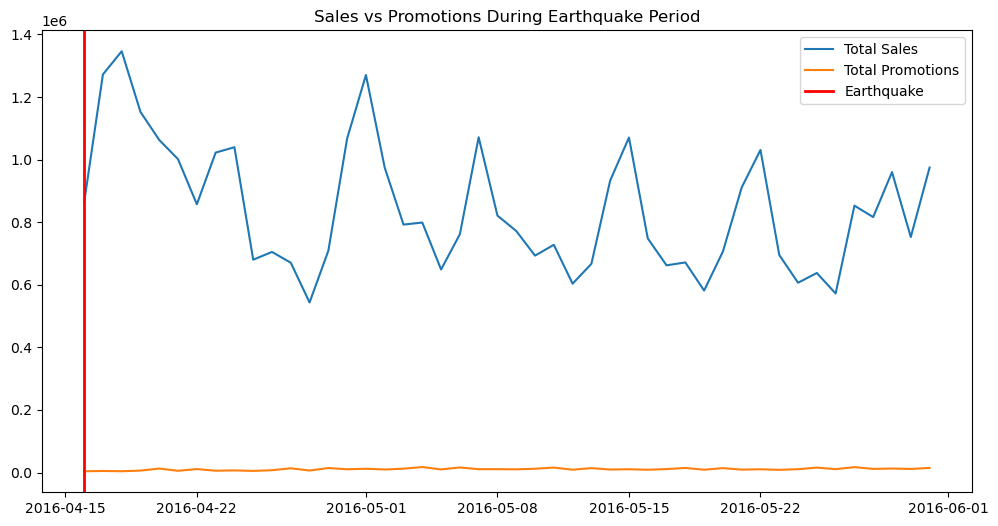

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Earthquake window
start = '2016-04-16'
end = '2016-05-31'

eq_df = df[(df['date'] >= start) & (df['date'] <= end)].copy()

# Aggregate by date
daily_eq = eq_df.groupby('date').agg({
    'sales': 'sum',
    'onpromotion': 'sum'
}).reset_index()

# Promotion flag
daily_eq['has_promo'] = (daily_eq['onpromotion'] > 0).astype(int)

# Average sales comparison
promo_sales = daily_eq[daily_eq['has_promo']==1]['sales'].mean()
no_promo_sales = daily_eq[daily_eq['has_promo']==0]['sales'].mean()

print("Average Sales WITH Promotion:", promo_sales)
print("Average Sales WITHOUT Promotion:", no_promo_sales)

# Plot
plt.figure(figsize=(12,6))
plt.plot(daily_eq['date'], daily_eq['sales'], label='Total Sales')
plt.plot(daily_eq['date'], daily_eq['onpromotion'], label='Total Promotions')

plt.axvline(pd.to_datetime('2016-04-16'), color='red', linewidth=2, label='Earthquake')

plt.title("Sales vs Promotions During Earthquake Period")
plt.legend()
plt.show()

In [ ]:
"
What We See in the Graph:

🔴 Red Line → April 16 (Earthquake)
Immediately after that:
📈 Sales (Blue Line)
Sharp spike right after earthquake
Highest peak in the entire window
Then gradual decline
Weekly pattern resumes afterward
🟠 Promotions (Orange Line)
Very small variation
No major spike immediately after earthquake
Slight increases later, but not dramatic

Interpretation
1️⃣ Sales Spike Was NOT Promotion Driven

Notice:
Sales jump sharply
Promotions remain almost flat
👉 This confirms panic buying / emergency stocking behavior.
People bought essentials regardless of discounts.

Promotions Slightly Increase Later
After sales drop from peak:
- Promotions show mild increase
- Likely reactive strategy to stabilize revenue
This explains result:
Correlation = -0.31
Because:
High sales occurred when promotions were low
Promotions increased when sales started falling

Analysis shows:

✅ Earthquake caused demand spike
✅ Promotions were not the driver
✅ Promotions were reactive
✅ Disaster effect dominates normal seasonality

In [38]:
correlation = daily_eq['sales'].corr(daily_eq['onpromotion'])
print("Correlation between Sales and Promotions:", correlation)

Correlation between Sales and Promotions: -0.30859613216992804


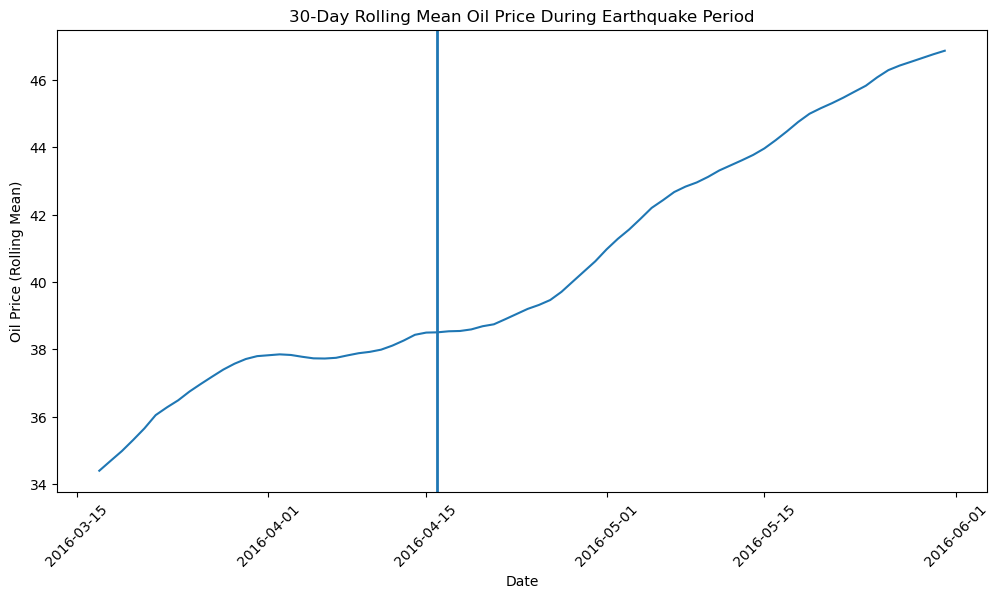

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Earthquake period window (30 days before & after optional)
start_date = '2016-03-17'
end_date   = '2016-05-31'

earthquake_date = pd.to_datetime('2016-04-16')

# Filter window
oil_eq = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Aggregate daily (important if multiple stores)
oil_daily = oil_eq.groupby('date').agg({
    'oil_rolling_30': 'mean'
}).reset_index()

# Plot
plt.figure(figsize=(12,6))
plt.plot(oil_daily['date'],
         oil_daily['oil_rolling_30'])

plt.axvline(earthquake_date, linewidth=2)

plt.title('30-Day Rolling Mean Oil Price During Earthquake Period')
plt.xlabel('Date')
plt.ylabel('Oil Price (Rolling Mean)')
plt.xticks(rotation=45)
plt.show()

In [161]:
"
Before Earthquake (Before April 16, 2016):

Oil price rolling mean was steadily increasing
Around $34 → $38
Smooth upward trend
No sudden jumps or drops
This indicates a stable macroeconomic recovery phase in oil prices.

At Earthquake (April 16, 2016 — Blue Vertical Line)
❗ No structural break
❗ No sudden spike
❗ No sudden crash

The trend continues smoothly upward.
This means:
The earthquake did NOT impact oil prices.
    
Which makes sense because oil prices are global market driven, not local shock driven.

After Earthquake

Oil price continues strong upward movement
Around $38 → $47
Even slightly steeper slope after late April

This is part of a broader global oil recovery in 2016.

Important Insight for Your Model:

Compared this with your sales graph:
Sales showed a temporary spike
Oil showed a smooth macro trend
So:
📌 Sales movement during earthquake was behavioral / local demand driven, not oil-price driven.

That’s a strong modeling insight.

| Variable     | Behavior                    |
| ------------ | --------------------------- |
| Sales        | Short spike then normalize  |
| Transactions | Spike with sales            |
| Promotions   | Weak / negative correlation |
| Oil Price    | Smooth upward trend         |

So earthquake effect = temporary demand shock, not macroeconomic shock.
    

SyntaxError: unterminated string literal (detected at line 1) (647215711.py, line 1)

In [ ]:
#Create Feature store

In [40]:
#Prepare Data
'''
Feature Store requires:
Record identifier column
Event time column as string
'''

df['store_family_id'] = (
    df['store_nbr'].astype(str) + "_" + df['family']
)


# Convert datetime columns
df['date'] = df['date'].astype(str)
df['event_time'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# Double check
print(df.dtypes)

id                         int64
date                      object
store_nbr                  int64
family                    object
sales                    float64
onpromotion                int64
transactions             float64
city                      object
state                     object
store_type                object
cluster                    int64
dcoilwtico               float64
is_national              float64
is_regional              float64
is_local                 float64
year                       int32
month                      int32
day                        int32
dayofweek                  int32
weekofyear                 int64
is_weekend                 int64
is_month_start             int64
is_month_end               int64
sales_lag_1              float64
sales_lag_7              float64
sales_lag_14             float64
sales_lag_28             float64
sales_rolling_mean_7     float64
rolling_mean_14          float64
sales_rolling_mean_30    float64
promo_last

In [41]:
df['event_time'].isna().sum()

0

In [42]:
# Create feature group object
feature_group = FeatureGroup(
    name="store-sales-feature-group_version1",
    sagemaker_session=session
)

# Load feature definitions
feature_group.load_feature_definitions(data_frame=df)

# Create feature group
feature_group.create(
    s3_uri=f"s3://{BUCKET}/feature-store/",
    record_identifier_name="store_family_id",
    event_time_feature_name="event_time",
    role_arn=role,
    enable_online_store=True
)

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:435058202789:feature-group/store-sales-feature-group_version1',
 'ResponseMetadata': {'RequestId': '5cc011d8-a160-4828-bf43-5dc8977a07a6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5cc011d8-a160-4828-bf43-5dc8977a07a6',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'content-security-policy': "frame-ancestors 'none'",
   'cache-control': 'no-cache, no-store, must-revalidate',
   'x-content-type-options': 'nosniff',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '111',
   'date': 'Sun, 22 Feb 2026 11:51:50 GMT'},
  'RetryAttempts': 0}}

In [45]:
feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:435058202789:feature-group/store-sales-feature-group_version1',
 'FeatureGroupName': 'store-sales-feature-group_version1',
 'RecordIdentifierFeatureName': 'store_family_id',
 'EventTimeFeatureName': 'event_time',
 'FeatureDefinitions': [{'FeatureName': 'id', 'FeatureType': 'Integral'},
  {'FeatureName': 'date', 'FeatureType': 'String'},
  {'FeatureName': 'store_nbr', 'FeatureType': 'Integral'},
  {'FeatureName': 'family', 'FeatureType': 'String'},
  {'FeatureName': 'sales', 'FeatureType': 'Fractional'},
  {'FeatureName': 'onpromotion', 'FeatureType': 'Integral'},
  {'FeatureName': 'transactions', 'FeatureType': 'Fractional'},
  {'FeatureName': 'city', 'FeatureType': 'String'},
  {'FeatureName': 'state', 'FeatureType': 'String'},
  {'FeatureName': 'store_type', 'FeatureType': 'String'},
  {'FeatureName': 'cluster', 'FeatureType': 'Integral'},
  {'FeatureName': 'dcoilwtico', 'FeatureType': 'Fractional'},
  {'FeatureName': 'is_national', 'F

In [ ]:
feature_group.ingest(data_frame=df, max_workers=3, wait=True)

In [ ]:
"
This will:

Store data in Offline Store (S3)
Store data in Online Store
Create Athena table automatically

In [ ]:
"
We now have:

- A registered feature group
- Schema stored
- Data versioned
- Features queryable
- Production ready

This is enterprise-level ML architecture